In [1]:
from ipynb.fs.full.utils import *

In [2]:
def compare_faces_api(source_file, target_file, threshold=0, bucket=None):

    client = boto3.client('rekognition')
    
    if bucket is None:
        source = open("../images/" + source_file,'rb')
        target = open("../images/" + target_file,'rb')
        response = client.compare_faces(SimilarityThreshold = threshold,
                                      SourceImage = {'Bytes': source_file.read()},
                                      TargetImage = {'Bytes': target_file.read()})
        source.close()
        target.close()     
    
    else:
        response = client.compare_faces(SimilarityThreshold = threshold,
                                      SourceImage = {'S3Object':{'Bucket':bucket,'Name':source_file}},
                                      TargetImage = {'S3Object':{'Bucket':bucket,'Name':target_file}})
    
    similarities = []
    print(response)
    for match in response['FaceMatches']:
        box = match['Face']['BoundingBox']
        similarity = match['Similarity']
        confidence = match['Face']['Confidence']
        
        similarities.append([box, similarity, confidence])
        
    return similarities 

In [3]:
def display_comparison(
    source, 
    target, 
    bucket,
    adaptive_resize=True
):
    get_object(bucket, source, "../images/" + source)
    get_object(bucket, target, "../images/" + target)
    
    source_image = Image.open("../images/" + source)
    target_image = Image.open("../images/" + target)
    
    if adaptive_resize:
        if source_image.size[0] > target_image.size[0]:
            source_image = resize(source_image, width = target_image.size[0])
        else:
            target_image = resize(target_image, width = source_image.size[0])

        if source_image.size[1] > target_image.size[1]:
            source_image = resize(source_image, height = target_image.size[1])
        else:
            target_image = resize(target_image, height = source_image.size[1])
    else:
        if source_image.size[0] > source_image.size[1]:
            source_image = resize(
                source_image, 
                width = 800, 
                height=int(source_image.size[1]*800/source_image.size[0])
            )
        else:
            source_image = resize(
                source_image, 
                height = 800, 
                width=int(source_image.size[0]*800/source_image.size[1])
            )

        if target_image.size[0] > target_image.size[1]:
            target_image = resize(
                target_image, 
                width = 800, 
                height=int(target_image.size[1]*800/target_image.size[0])
            )
        else:
            target_image = resize(
                target_image, 
                height = 800, 
                width=int(target_image.size[0]*800/target_image.size[1])
            )

    concat = concat_horizontal(source_image, target_image)
    source_image.close()
    target_image.close()
    
    result = compare_faces_api(source, target, bucket = bucket)
    if len(result) == 0:
        result = [[None, "No match"]]
    
    draw = ImageDraw.Draw(concat)
    for item in result:
        similarity = 'Match similarity: %.3f' % item[1]
        confidence = 'Match confidence: %.3f' % item[2]
        
        fnt_size = int(15 * concat.width/800)
        try:
            fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", fnt_size)
        except Exception:
            fnt = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf", fnt_size)
        
        text_fill = (255,255,255,128)
        
        w, h = fnt.getsize(confidence)
        pos_y = int(concat.height/2 + 3*h/4)
        pos_x = int(concat.width/2 - w/2)
        draw.rectangle((pos_x, pos_y, pos_x + w, pos_y + h), fill='black')
        draw.rectangle((pos_x, pos_y+fnt_size, pos_x + w, pos_y+fnt_size + h), fill='black')


        draw.text((pos_x, pos_y), similarity, font=fnt, fill=text_fill)
        draw.text((pos_x, pos_y+fnt_size), confidence, font=fnt, fill=text_fill)
    
    concat.show()

{'SourceImageFace': {'BoundingBox': {'Width': 0.23037202656269073, 'Height': 0.2663889229297638, 'Left': 0.3754080832004547, 'Top': 0.06540403515100479}, 'Confidence': 99.99859619140625}, 'FaceMatches': [{'Similarity': 98.84744262695312, 'Face': {'BoundingBox': {'Width': 0.28653383255004883, 'Height': 0.28233203291893005, 'Left': 0.34621545672416687, 'Top': 0.15297773480415344}, 'Confidence': 99.99626922607422, 'Landmarks': [{'Type': 'eyeLeft', 'X': 0.42127060890197754, 'Y': 0.25072118639945984}, {'Type': 'eyeRight', 'X': 0.5500790476799011, 'Y': 0.25200438499450684}, {'Type': 'mouthLeft', 'X': 0.4325841963291168, 'Y': 0.3513302206993103}, {'Type': 'mouthRight', 'X': 0.5398565530776978, 'Y': 0.3522289991378784}, {'Type': 'nose', 'X': 0.4941022992134094, 'Y': 0.29319578409194946}], 'Pose': {'Roll': 0.06357578188180923, 'Yaw': 4.972657203674316, 'Pitch': 14.206024169921875}, 'Quality': {'Brightness': 84.94340515136719, 'Sharpness': 92.22801208496094}}}], 'UnmatchedFaces': [], 'ResponseMe

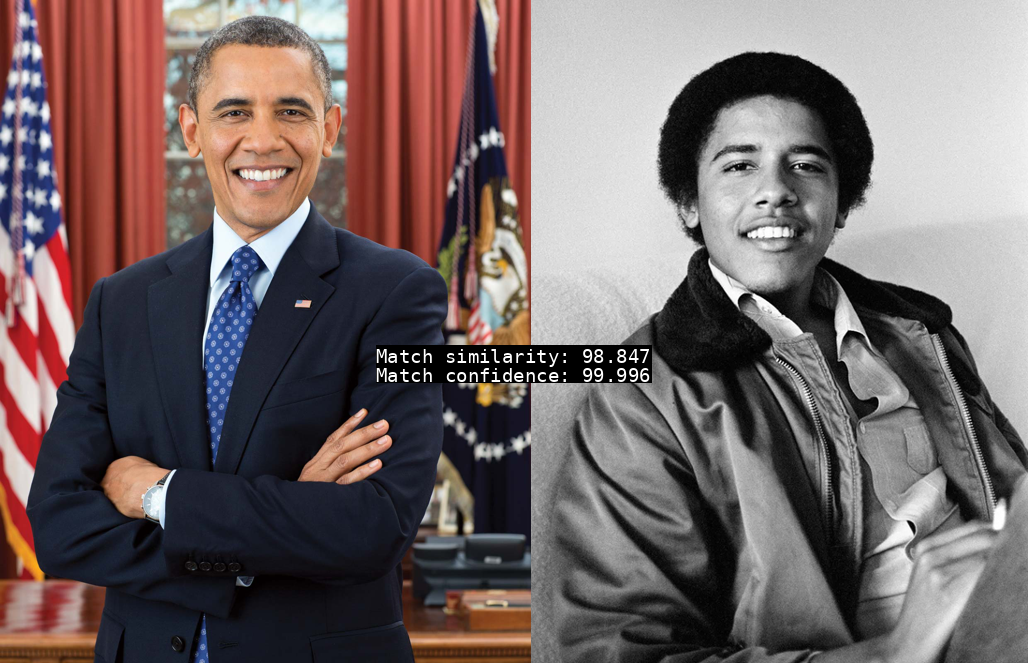

In [4]:
source = 'obama_1.jpg'
target = 'obama_2.png'
bucket = 'labs-rekognition-demo-bucket'

display_comparison(source, target, bucket)

{'SourceImageFace': {'BoundingBox': {'Width': 0.23099038004875183, 'Height': 0.20615507662296295, 'Left': 0.4035157859325409, 'Top': 0.12104485929012299}, 'Confidence': 99.9994125366211}, 'FaceMatches': [{'Similarity': 92.05809020996094, 'Face': {'BoundingBox': {'Width': 0.2011154741048813, 'Height': 0.38009876012802124, 'Left': 0.3071209192276001, 'Top': 0.1511872261762619}, 'Confidence': 99.99639129638672, 'Landmarks': [{'Type': 'eyeLeft', 'X': 0.38364917039871216, 'Y': 0.29406964778900146}, {'Type': 'eyeRight', 'X': 0.47142279148101807, 'Y': 0.3104535937309265}, {'Type': 'mouthLeft', 'X': 0.3796638548374176, 'Y': 0.4304443597793579}, {'Type': 'mouthRight', 'X': 0.4528931975364685, 'Y': 0.4436769187450409}, {'Type': 'nose', 'X': 0.4353282153606415, 'Y': 0.3677586615085602}], 'Pose': {'Roll': 8.0510892868042, 'Yaw': 10.402182579040527, 'Pitch': 10.503657341003418}, 'Quality': {'Brightness': 93.7896728515625, 'Sharpness': 89.85481262207031}}}], 'UnmatchedFaces': [], 'ResponseMetadata':

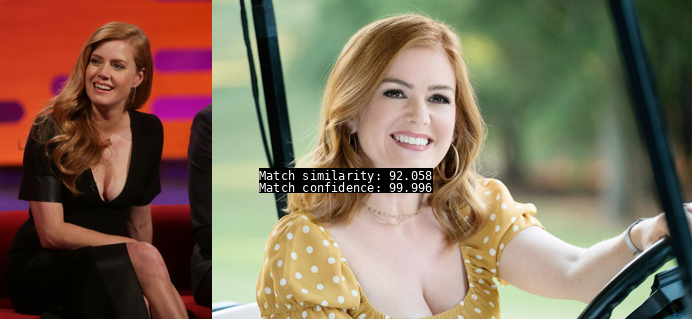

In [5]:
source = 'amy_adams_5.jpg'
target = 'isla_fisher_3.jpg'
bucket = 'labs-rekognition-demo-bucket'

display_comparison(source, target, bucket)

{'SourceImageFace': {'BoundingBox': {'Width': 0.2854171097278595, 'Height': 0.6530877947807312, 'Left': 0.22669076919555664, 'Top': 0.11644914746284485}, 'Confidence': 99.99302673339844}, 'FaceMatches': [{'Similarity': 50.93675994873047, 'Face': {'BoundingBox': {'Width': 0.324798583984375, 'Height': 0.4280630350112915, 'Left': 0.3700172007083893, 'Top': 0.16009435057640076}, 'Confidence': 99.9983901977539, 'Landmarks': [{'Type': 'eyeLeft', 'X': 0.4706343114376068, 'Y': 0.3187846541404724}, {'Type': 'eyeRight', 'X': 0.6085854172706604, 'Y': 0.32531917095184326}, {'Type': 'mouthLeft', 'X': 0.4754447937011719, 'Y': 0.4675687551498413}, {'Type': 'mouthRight', 'X': 0.5903743505477905, 'Y': 0.4729407727718353}, {'Type': 'nose', 'X': 0.540862500667572, 'Y': 0.3938335180282593}], 'Pose': {'Roll': 1.9094481468200684, 'Yaw': 2.434152126312256, 'Pitch': 7.35085391998291}, 'Quality': {'Brightness': 82.79177856445312, 'Sharpness': 92.22801208496094}}}], 'UnmatchedFaces': [], 'ResponseMetadata': {'R

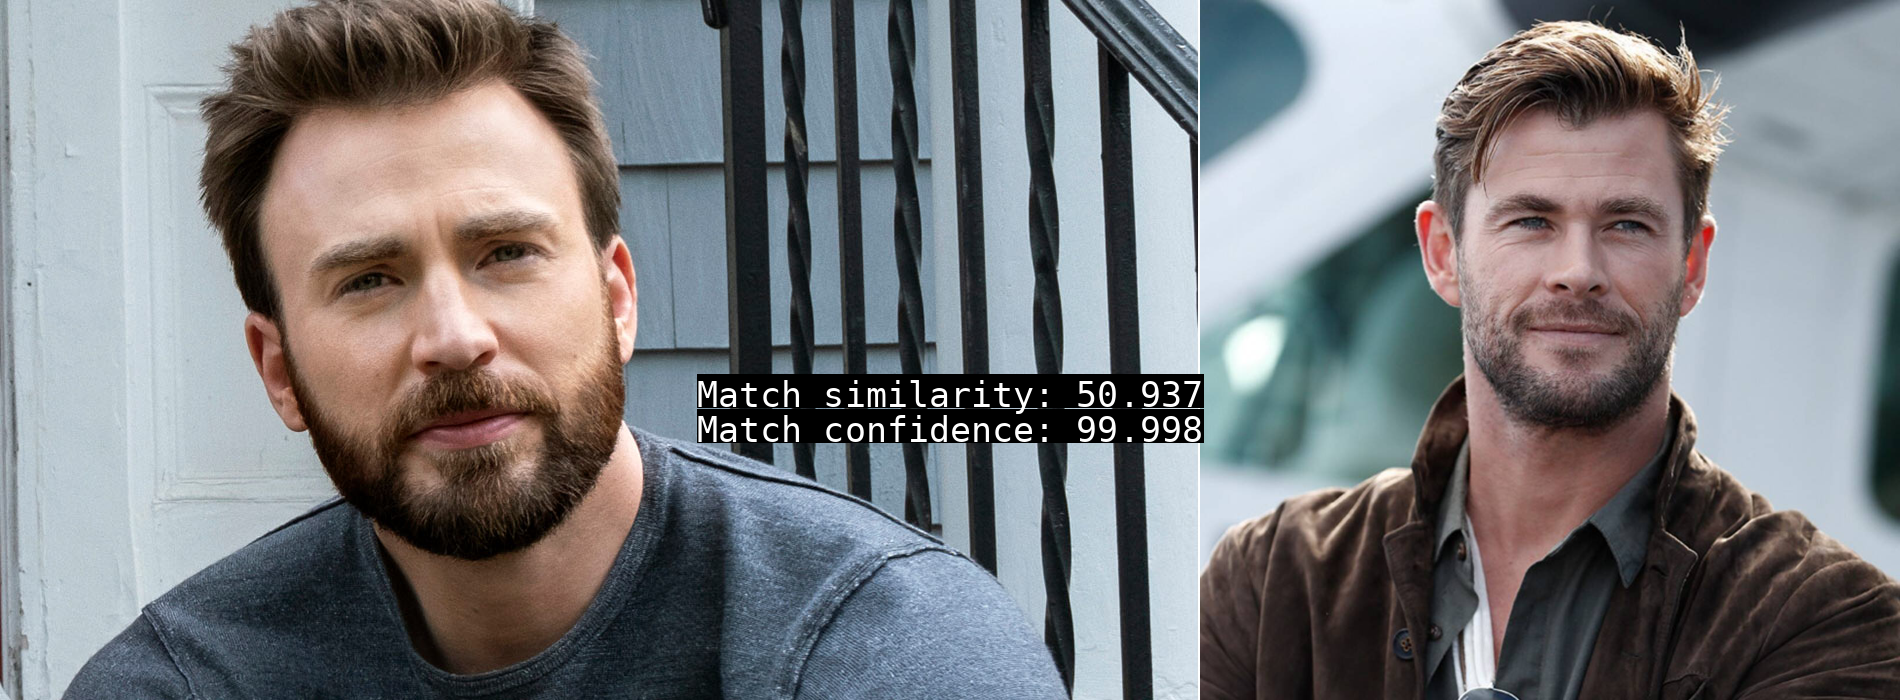

In [6]:
source = 'chris_evans_1.jpg'
target = 'chris_hemsworth.jpg'
bucket = 'labs-rekognition-demo-bucket'

display_comparison(source, target, bucket)